In [1]:
import Pkg
Pkg.activate("../../Tasks2D/")

  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [2]:
using Revise
include("src/model1.jl")
# Loads in: uniform_agent_pos, motion_model, observe_noisy_distances,
# meandering_wallavoiding_controller

Precompiling GenPOMDPs
  ✓ GenPOMDPs
  1 dependency successfully precompiled in 3 seconds. 66 already precompiled.


GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_meandering_wallavoiding_controller#295", Bool[0, 0], false), nothing)

In [3]:
import LinearAlgebra

In [4]:
# POMDP for an agent moving around in the environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                     ⇝ state
    motion_model,            # STEP   : prev_state, action, params ⇝ state
    observe_noisy_distances, # OBS    : state, params              ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params      → utility
);

Set up several distributions over POMDP rollouts.  We'll use these distributions to generate data to run inference in.

In [5]:
rollout_model = GenPOMDPs.RolloutModel(pomdp, meandering_wallavoiding_controller);

Some default POMDP params:

In [6]:
_get_params(map) = (;
    # map = GridWorlds.load_custom_map(5),
    map=map,
    step = (; Δ = .5, σ = 0.4),
    obs = (; fov = 2π, n_rays = 90, orientation = π/2,
        # I think currently only σ is used
        wall_sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0, σ=0.005
        )
    )
)

MAPSTR = """
wwwwwwwwwwwwwwwww
w               w
w        w      w
w        w      w
w        w      w
w        w      w
w               w
w               w
w               w
wwwwwwwwwwwwwwwww
"""
params = _get_params(GridWorlds.mapstr_to_gridworld(MAPSTR));

Test data generation:

In [7]:
trace = Gen.simulate(rollout_model, (100, params))
GenPOMDPs.state_sequence(trace)[1:10]

10-element Vector{@NamedTuple{pos::Vector{Float64}, t::Int64, hit_wall::Bool}}:
 (pos = [14.129358915569341, 6.728749886216582], t = 0, hit_wall = 0)
 (pos = [13.417420825379951, 7.1613413234132315], t = 1, hit_wall = 0)
 (pos = [13.799590132947586, 7.0085518160781834], t = 2, hit_wall = 0)
 (pos = [13.69906394975344, 6.920642213134768], t = 3, hit_wall = 0)
 (pos = [14.541902044038189, 7.156244829314], t = 4, hit_wall = 0)
 (pos = [14.664741132501877, 7.738177152553133], t = 5, hit_wall = 0)
 (pos = [14.617841425602544, 7.631343261542153], t = 6, hit_wall = 0)
 (pos = [14.946420710927336, 7.2771887603045675], t = 7, hit_wall = 0)
 (pos = [15.43186034891706, 7.214755684255466], t = 8, hit_wall = 0)
 (pos = [14.572772657758666, 6.982691024660433], t = 9, hit_wall = 0)

In [8]:
GenPOMDPs.action_sequence(trace)[1:10]

10-element Vector{Symbol}:
 :left
 :up
 :up
 :up
 :up
 :up
 :right
 :right
 :left
 :left

### Inference POMDP

In [9]:
@gen function ipomdp_init(params)
    state ~ uniform_agent_pos(params.params)
    return state
end
@gen function ipomdp_step(prev, inference_action, params)
    action = params.actions[prev.t + 1]
    state ~ motion_model(prev, action, params.params)
    return state
end
@gen function ipomdp_obs(prev, params)
    observation ~ observe_noisy_distances(prev, params.params)
    return observation
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##ipomdp_obs#445", Bool[0, 0], false)

In [10]:
"""
    InferenceAction(found_position:Bool, inferred_position::Vector, inference_runtime::Float64)
- found_position - did the inference algorithm find a position, or give up?
- inferred_position - the position that the inference algorithm inferred, if any
- inference_runtime is the time it took to run the inference algorithm, in milliseconds.
"""
InferenceAction = NamedTuple{
    (:found_position, :inferred_position, :inference_runtime),
    Tuple{Bool, Vector{Float64}, Float64}
}
function cost(pos, ia::InferenceAction)
    if ia.found_position
        errcost = LinearAlgebra.norm(pos - ia.inferred_position)^2
    else
        # Penalty of 1 if infernce says it didn't find the position
        errcost = 1.
    end
    # Scale inference runtime by 2000, so it is better to spend
    # 2 seconds and get the position right than to totally give up.
    timecost = ia.inference_runtime/2000

    return errcost + timecost
end

inference_pomdp = GenPOMDPs.GenPOMDP(
    ipomdp_init,
    ipomdp_step,
    ipomdp_obs,
    # Utility = -cost
    (state, inference_action) -> -cost(state.pos, inference_action)
);

In [11]:
ictm = GenPOMDPs.ControlledTrajectoryModel(inference_pomdp)
ias = [InferenceAction((true, x.pos, 0.)) for x in GenPOMDPs.state_sequence(trace)]
ipomdp_params = (params=params, actions=GenPOMDPs.action_sequence(trace))
itrace = GenPOMDPs.simulate(ictm, (100, ias, ipomdp_params))
# GenPOMDPs.undiscounted_utility(inference_pomdp, itrace)

GenPOMDPs.var"##StaticIRTrace__ControlledTrajectoryModel#516"(100, @NamedTuple{found_position::Bool, inferred_position::Vector{Float64}, inference_runtime::Float64}[(found_position = 1, inferred_position = [14.129358915569341, 6.728749886216582], inference_runtime = 0.0), (found_position = 1, inferred_position = [13.417420825379951, 7.1613413234132315], inference_runtime = 0.0), (found_position = 1, inferred_position = [13.799590132947586, 7.0085518160781834], inference_runtime = 0.0), (found_position = 1, inferred_position = [13.69906394975344, 6.920642213134768], inference_runtime = 0.0), (found_position = 1, inferred_position = [14.541902044038189, 7.156244829314], inference_runtime = 0.0), (found_position = 1, inferred_position = [14.664741132501877, 7.738177152553133], inference_runtime = 0.0), (found_position = 1, inferred_position = [14.617841425602544, 7.631343261542153], inference_runtime = 0.0), (found_position = 1, inferred_position = [14.946420710927336, 7.2771887603045675]

In [12]:
GenPOMDPs.undiscounted_utility(inference_pomdp, itrace)

-4650.317399192452

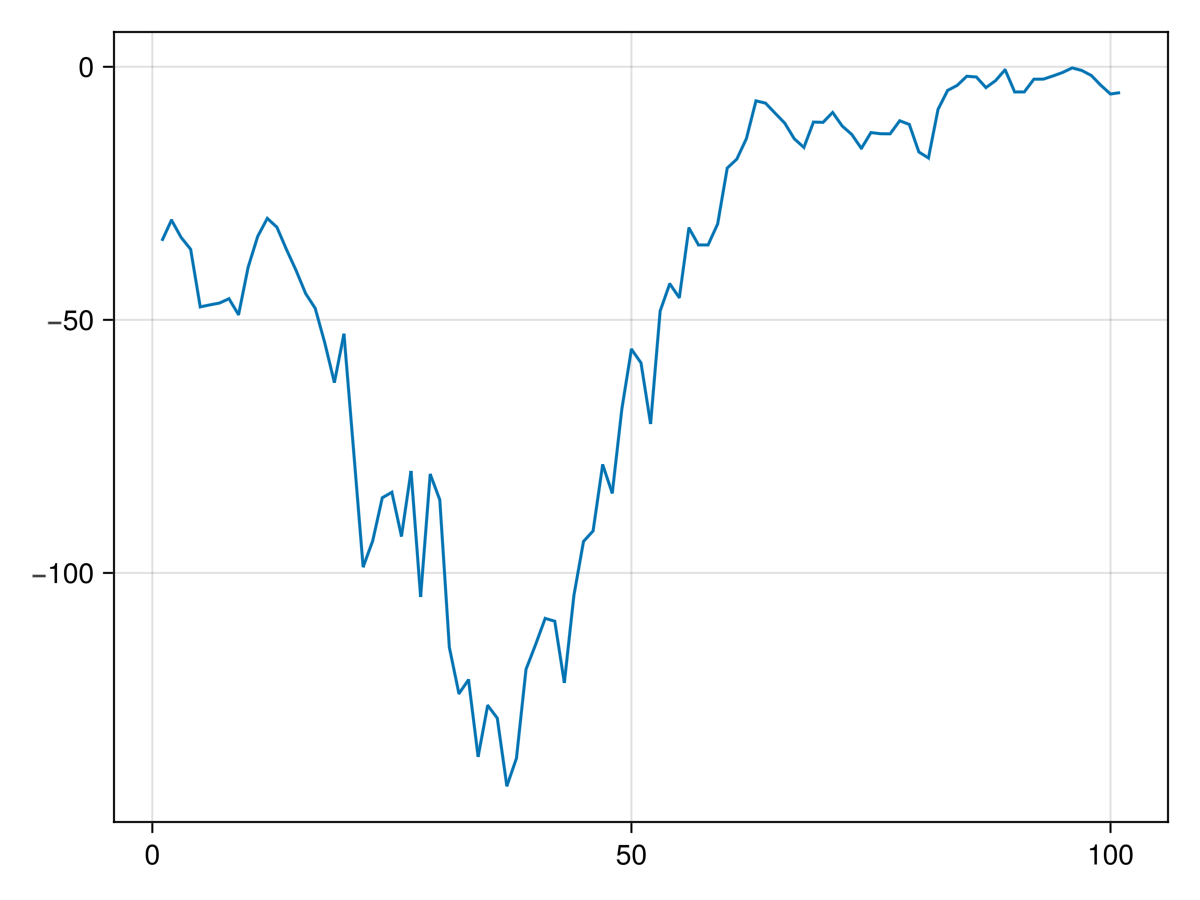

In [13]:
import Makie
import GLMakie
f = Makie.lines([inference_pomdp.utility(s, a) for (s, a) in zip(GenPOMDPs.state_sequence(itrace), GenPOMDPs.action_sequence(itrace))])

Unsurprisingly, this has quite a high cost.  Would have been way better to just report "we don't konw" at each time step.

Now we'll start actually implementing inference, to hopefully do better.

In [40]:
include("src/inference_constructors.jl")

_bpf = make_bpf(pomdp, params, 10)
(_bpf_init, _bpf_update) = _bpf

BPFControllerState = NamedTuple{
    (:ipomdp_params, :pfstate),
    Tuple{Any, Any}
}
# Main inference controller function
@gen function __bootstrap_pf_inference_controller(cstate, observation)
    observation = choicemap((:obs, observation))
    if isnothing(cstate.pfstate)
        # Initialize the PF
        new_pf_state = _bpf_init(observation)
    else
        # Update the PF
        t = GenPOMDPs.state_sequence(cstate.pfstate.traces[1])[end].t + 1
        action = cstate.ipomdp_params.actions[t]
        new_pf_state = _bpf_update(cstate.pfstate, action, observation)
    end

    tr = Gen.sample_unweighted_traces(new_pf_state, 1)[1]
    inference_action = InferenceAction((true, GenPOMDPs.state_sequence(tr)[end].pos, NaN))
    new_cstate = BPFControllerState((cstate.ipomdp_params, new_pf_state))
    return new_cstate, inference_action
end
# This just wraps the main inference controller function to time it
@gen function _bootstrap_pf_inference_controller(cstate, observation)
    t = Dates.now()
    new_cstate, ia0 = {:inner} ~ __bootstrap_pf_inference_controller(cstate, observation)
    Δt = (Dates.now() - t).value
    
    return InferenceAction((ia0.found_position, ia0.inferred_position, Δt)), new_cstate
end
# Initialize the inference controller with the params, and no
# inference state (it will initialize the PF itself)
bootstrap_pf_inference_controller = GenPOMDPs.Controller(
    _bootstrap_pf_inference_controller,
    BPFControllerState((ipomdp_params, nothing))
);

In [41]:
bpf_inference_rollout_model = GenPOMDPs.RolloutModel(inference_pomdp, bootstrap_pf_inference_controller)
bpf_itrace = GenPOMDPs.simulate(bpf_inference_rollout_model, (10, ipomdp_params));

In [43]:
bpf_itrace_ext, _ = Gen.update(bpf_itrace, (100, ipomdp_params), (Gen.UnknownChange(), Gen.NoChange()), Gen.EmptyChoiceMap());

In [44]:
GenPOMDPs.action_sequence(bpf_itrace_ext)[1:10]

10-element Vector{@NamedTuple{found_position::Bool, inferred_position::Vector{Float64}, inference_runtime::Float64}}:
 (found_position = 1, inferred_position = [8.914635780750585, 6.142159574989874], inference_runtime = 6138.0)
 (found_position = 1, inferred_position = [8.546223773304813, 6.074452076699405], inference_runtime = 399.0)
 (found_position = 1, inferred_position = [8.78549546564205, 6.740347313181088], inference_runtime = 3.0)
 (found_position = 1, inferred_position = [8.975347083741672, 6.982926197037356], inference_runtime = 4.0)
 (found_position = 1, inferred_position = [8.992103319471195, 7.066133140960296], inference_runtime = 4.0)
 (found_position = 1, inferred_position = [8.992103319471195, 7.066133140960296], inference_runtime = 4.0)
 (found_position = 1, inferred_position = [8.80496925938622, 6.925306889249385], inference_runtime = 4.0)
 (found_position = 1, inferred_position = [8.971853896178825, 7.093825995615657], inference_runtime = 4.0)
 (found_position = 1, i

In [57]:
include("src/viz_constructors.jl")

pf_result_gif(trace, bpf_itrace_ext)

LoadError: MethodError: no method matching animateable_pf_results(::GridWorlds.FGridWorld, ::var"#269#278"{GenPOMDPs.var"##StaticIRTrace__RolloutModel#377"}, ::var"#271#280"{Vector{Gen.ParticleFilterState{GenPOMDPs.var"##StaticIRTrace__ControlledTrajectoryModel#3984"}}}, ::var"#274#283"{Vector{Gen.ParticleFilterState{GenPOMDPs.var"##StaticIRTrace__ControlledTrajectoryModel#3984"}}}; fr_to_gt_obs::var"#275#284"{GenPOMDPs.var"##StaticIRTrace__RolloutModel#377"}, fr_to_particle_obss::var"#276#285", n_panels::Int64, tail_length::Int64, labeltext::String, label_fontsize::Int64, filename::String, show_lines_to_walls::Bool)

[0mClosest candidates are:
[0m  animateable_pf_results(::Any, ::Any, ::Any, ::Any; fig_xsize, fr_to_gt_obs, fr_to_particle_obss, show_lines_to_walls)[91m got unsupported keyword arguments "n_panels", "tail_length", "labeltext", "label_fontsize", "filename"[39m
[0m[90m   @[39m [33mGridWorlds[39m [90m~/Developer/research/fall2023/cocosci/tasks2D/GridWorlds/src/viz/[39m[90m[4mvisualize.jl:110[24m[39m


In [56]:
get_args(trace)

(100, (map = GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.w